### Домашнее задание: Функции потерь и оптимизация

Дана статистика пользователей adult.csv.
Получите значения AUC для различных моделей и их параметров. Попробуйте построить модель с улучшенным значением AUC, чем в примерах на занятии.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
adult = pd.read_csv('/home/data/netology_ml/data/hw 5 (loss functions)/adult.csv')

In [3]:
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Подготовим данные

In [4]:
# Целевая переменная будет бинарной
le_income = LabelEncoder()
adult.income = le_income.fit_transform(adult.income) 

In [5]:
# Делаем one hot encoding для категориальных переменных
adult = pd.get_dummies(adult)

In [6]:
# Делаем train-test split
X_train, X_test, y_train, y_test = train_test_split(adult.drop(columns='income'), adult.income, test_size=0.2, random_state=42)

In [7]:
# Нормализуем непрерывные переменные
for col in X_train.columns:
    if X_train[col].dtype != 'object':
        X_train[col] = StandardScaler().fit_transform(np.reshape(X_train[col].tolist(), (-1, 1)))

for col in X_test.columns:
    if X_test[col].dtype != 'object':
        X_test[col] = StandardScaler().fit_transform(np.reshape(X_test[col].tolist(), (-1, 1)))

/home/data/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Отлично, данные готовы. Начнем перебор моделей.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

lr = LogisticRegression()
nb = GaussianNB()
dt = DecisionTreeClassifier()

In [49]:
classifiers = {'Logistic Regression': lr, 'Gaussian Naive Bayes': nb, 'Decision Tree': dt}

In [50]:
for name, clf in classifiers.items():
    print(name, '- done')
    clf.fit(X_train, y_train)

Logistic Regression - done
Gaussian Naive Bayes - done
Decision Tree - done


Подготовим визуализатор

In [62]:
import matplotlib.pyplot as plt
def show_auc(y, y_pred, plot_label=''):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=plot_label)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc=4)

Logistic Regression
Train AUC score:	 0.9071618131920661
Test AUC score: 	 0.9106722111577628


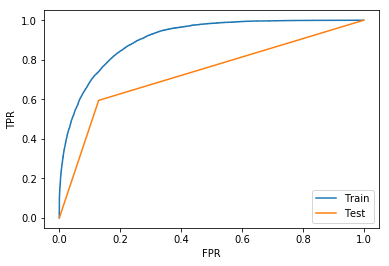

--------------------------------------------------

Gaussian Naive Bayes
Train AUC score:	 0.8129642966212384
Test AUC score: 	 0.5


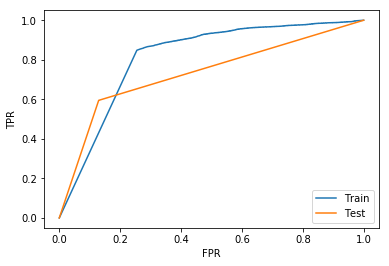

--------------------------------------------------

Decision Tree
Train AUC score:	 0.9999999551755031
Test AUC score: 	 0.7326382867662644


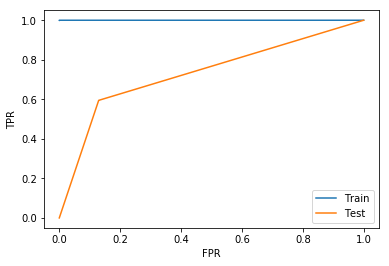

--------------------------------------------------



In [68]:
for name, clf in classifiers.items():
    print(name)
    print('Train AUC score:\t', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print('Test AUC score: \t', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    show_auc(y_train, clf.predict_proba(X_train)[:,1], plot_label='Train')
    show_auc(y_test, dt.predict_proba(X_test)[:,1], plot_label='Test')
    plt.show()
    print('--------------------------------------------------\n')

Очевидно, что лучше всех справилась логистическая регрессия.

Дерево решений сельно переобучилось. Попробуем подобрать перебрать паратметры дерева, чтобы добиться лучшего результата.

In [80]:
depths = np.arange(2, 19, 4)

Max depth = 2
Test AUC score: 	 0.8388486597991114
--------------------------------------------------

Max depth = 6
Test AUC score: 	 0.8807163405424562
--------------------------------------------------

Max depth = 10
Test AUC score: 	 0.8706963778054536
--------------------------------------------------

Max depth = 14
Test AUC score: 	 0.8431078635901047
--------------------------------------------------

Max depth = 18
Test AUC score: 	 0.8040626125786848
--------------------------------------------------



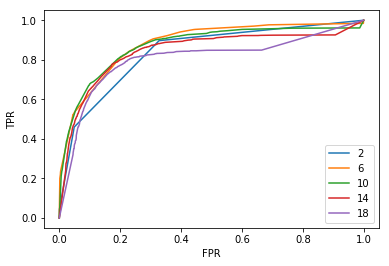

In [82]:
for i in depths:
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    print('Max depth =', i)
    print('Test AUC score: \t', roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))
    show_auc(y_test, dt.predict_proba(X_test)[:,1], plot_label=i)
    print('--------------------------------------------------\n')
plt.show()

Похоже, что оптимальная глубина находиться где-то в районе 6.

Посмотрим, так ли это. Применим алгоритм GridSearch.

In [84]:
from sklearn.model_selection import GridSearchCV

In [98]:
grid = {'max_depth': np.arange(7, 14),
        'max_leaf_nodes': np.arange(45, 56)
        }

gridsearch = GridSearchCV(dt, grid, scoring='roc_auc', cv=4, n_jobs=-1)

In [99]:
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'max_depth': 9, 'max_leaf_nodes': 54}

In [102]:
dt = DecisionTreeClassifier(max_depth=9, max_leaf_nodes=54)

Train AUC score: 	 0.9099618166288498
Test AUC score: 	 0.9018693389525606


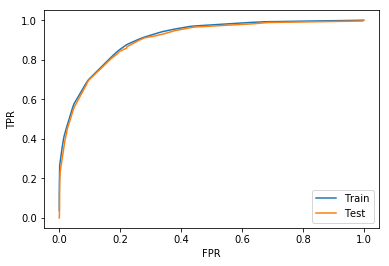

--------------------------------------------------



In [103]:
dt.fit(X_train, y_train)
print('Train AUC score: \t', roc_auc_score(y_train, dt.predict_proba(X_train)[:,1]))
print('Test AUC score: \t', roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))
show_auc(y_train, dt.predict_proba(X_train)[:,1], plot_label='Train')
show_auc(y_test, dt.predict_proba(X_test)[:,1], plot_label='Test')
plt.show()
print('--------------------------------------------------\n')

Отлично! Мы приблизили качество работы дерева решений к логистической регрессии.